# 1. 환경 설정

In [1]:
# 라이브러리 설정
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

# 랜덤 시드 고정
SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)  

# 구글 드라이브 폴더 마운트
from google.colab import drive, files
drive.mount('/gdrive')

Mounted at /gdrive


# 2. 데이터셋 준비

In [2]:
# 전력거래소 전력거래가격(SMP) 데이터 다운로드 (2018.1.1. ~ 2020.3.31)
# http://epsis.kpx.or.kr/epsisnew/selectEkmaSmpShdChart.do?menuId=040202

drive_path = "/gdrive/My Drive/"
smp = pd.read_csv(drive_path + "smp/smp.csv")

# 날짜 데이터를 time series 형식으로 변환
smp['date'] = pd.to_datetime(smp['date'])
smp['day_of_week'] = smp['date'].dt.dayofweek

print(smp.shape)   
smp.head()

(820, 5)


,date,smp_max,smp_min,smp_mean,day_of_week
0,2018-01-01,95.93,73.69,84.88,0
1,2018-01-02,95.70,88.36,92.57,1
2,2018-01-03,96.47,88.37,92.34,2
3,2018-01-04,98.09,88.37,92.14,3
4,2018-01-05,96.12,88.23,92.42,4


In [3]:
# Onehot Encoding
smp['day_of_week'] = smp['day_of_week'].astype('category')
smp = pd.get_dummies(smp, columns = ['day_of_week'], prefix='W', drop_first=True)

smp.head()

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
0,2018-01-01,95.93,73.69,84.88,0,0,0,0,0,0
1,2018-01-02,95.70,88.36,92.57,1,0,0,0,0,0
2,2018-01-03,96.47,88.37,92.34,0,1,0,0,0,0
3,2018-01-04,98.09,88.37,92.14,0,0,1,0,0,0
4,2018-01-05,96.12,88.23,92.42,0,0,0,1,0,0


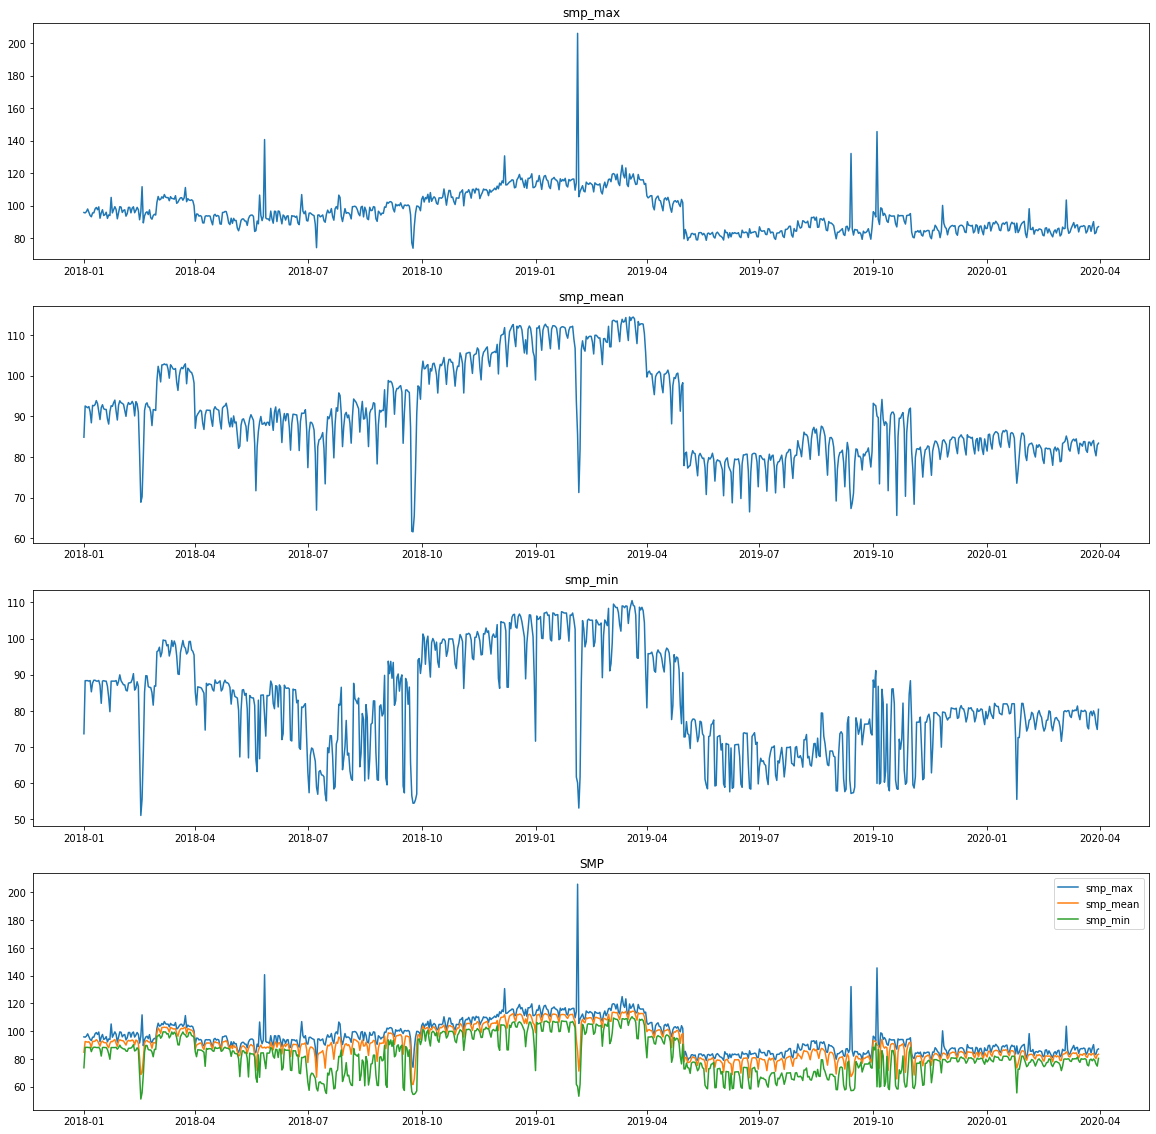

In [4]:
# 그래프 그리기
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

axes[0].plot(smp['date'], smp['smp_max'])
axes[0].set_title('smp_max')

axes[1].plot(smp['date'], smp['smp_mean'])
axes[1].set_title('smp_mean')

axes[2].plot(smp['date'], smp['smp_min'])
axes[2].set_title('smp_min')

axes[3].plot(smp['date'], smp['smp_max'], label='smp_max')
axes[3].plot(smp['date'], smp['smp_mean'], label='smp_mean')
axes[3].plot(smp['date'], smp['smp_min'], label='smp_min')
axes[3].set_title('SMP')
axes[3].legend()

plt.show()

# 3. 모델 학습

In [5]:
# Settings
train_split_idx = 729   # 2020.1.1. 행 인덱스 번호  
window_size = 10   # 과거 10일 동안의 시계열 데이터를 학습 데이터로 사용
future = 3     # 3일 이후의 타겟을 예측

# Features 
X_train = smp.iloc[:train_split_idx - window_size - future, 0:]   

# Targets
y_train = smp.iloc[window_size + future :train_split_idx, [3]]  # 'smp_mean' 열

print(X_train.shape, y_train.shape)

(716, 10) (716, 1)


In [6]:
X_train.head(15)

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
0,2018-01-01,95.93,73.69,84.88,0,0,0,0,0,0
1,2018-01-02,95.70,88.36,92.57,1,0,0,0,0,0
2,2018-01-03,96.47,88.37,92.34,0,1,0,0,0,0
3,2018-01-04,98.09,88.37,92.14,0,0,1,0,0,0
4,2018-01-05,96.12,88.23,92.42,0,0,0,1,0,0
5,2018-01-06,94.09,88.38,91.14,0,0,0,0,1,0
6,2018-01-07,93.31,85.28,88.42,0,0,0,0,0,1
7,2018-01-08,95.69,87.72,92.71,0,0,0,0,0,0
8,2018-01-09,95.71,88.48,92.61,1,0,0,0,0,0
9,2018-01-10,98.09,88.48,92.90,0,1,0,0,0,0


In [7]:
y_train.head(5)

,smp_mean
13,89.23
14,92.17
15,92.88
16,91.88
17,91.72


In [8]:
# X_test
test_start = train_split_idx - window_size - future  # 테스트 데이터의 시작 행  
test_end = smp.shape[0] - window_size - future
X_test = smp.iloc[test_start:test_end, 0:]

# y_test
# label_start =  + future # 테스트 데이터의 첫 번째 타겟 데이터 위치 
y_test = smp.iloc[train_split_idx:, [3]]  # 'smp_mean' 열 선택

print(X_test.shape, y_test.shape)

(91, 10) (91, 1)


In [9]:
X_test.head(15)

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
716,2019-12-19,87.62,80.90,84.64,0,0,1,0,0,0
717,2019-12-20,88.08,80.12,84.86,0,0,0,1,0,0
718,2019-12-21,83.45,79.85,82.37,0,0,0,0,1,0
719,2019-12-22,84.47,76.97,80.76,0,0,0,0,0,1
720,2019-12-23,88.43,78.22,84.16,0,0,0,0,0,0
721,2019-12-24,87.89,80.61,84.56,1,0,0,0,0,0
722,2019-12-25,83.20,79.87,81.53,0,1,0,0,0,0
723,2019-12-26,87.34,80.03,84.70,0,0,1,0,0,0
724,2019-12-27,87.69,80.56,84.66,0,0,0,1,0,0
725,2019-12-28,84.58,80.38,81.98,0,0,0,0,1,0


In [10]:
y_test.head(5)

,smp_mean
729,81.46
730,85.51
731,85.63
732,83.26
733,81.95


In [11]:
# Feature Scaling
X_train_scaled = X_train.loc[:, 'smp_max':]
X_test_scaled = X_test.loc[:, 'smp_max':]

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train_scaled.values)
X_train_scaled.loc[:, :] = scaler.transform(X_train_scaled.values)
X_test_scaled.loc[:, :] = scaler.transform(X_test_scaled.values)

In [12]:
# Mini Batch 크기로 시계열을 변환
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
train_data = timeseries_dataset_from_array( 
    X_train_scaled, y_train, sequence_length=window_size, batch_size=16)
test_data = timeseries_dataset_from_array( 
    X_test_scaled, y_test, sequence_length=window_size, batch_size=16)

print(train_data)
print(test_data)

<BatchDataset shapes: ((None, None, 9), (None, 1)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((None, None, 9), (None, 1)), types: (tf.float64, tf.float64)>


In [13]:
for batch in test_data.take(1):
    inputs, targets = batch

print("Input:", inputs.numpy().shape)
print("Target:", targets.numpy().shape)

Input: (16, 10, 9)
Target: (16, 1)


In [14]:
inputs[0]

<tf.Tensor: shape=(10, 9), dtype=float64, numpy=
array([[0.10309278, 0.50160013, 0.43581017, 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.10657975, 0.48846219, 0.43996975, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.07148272, 0.48391443, 0.39289091, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.07921468, 0.43540509, 0.36245037, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ],
       [0.10923287, 0.45645949, 0.42673473, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10513948, 0.49671551, 0.4342976 , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.06958763, 0.48425131, 0.37700889, 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10097029, 0.48694627, 0.4369446 , 0.        , 0.        ,
        

In [15]:
targets[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([81.46])>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

model = Sequential()
model.add(Input(shape=[10, 9]))

model.add(LSTM(units=32, return_sequences=False)) 
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


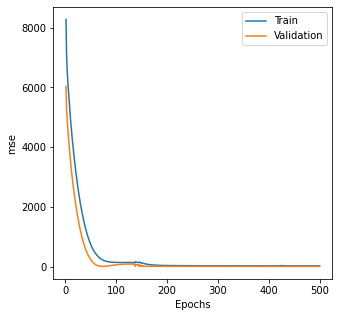

In [20]:
# 모델 훈련
history = model.fit(train_data, epochs=500, 
                    validation_data=test_data, 
                    verbose=0)

# 손실 함수 그래프
def plot_loss_curve(history, total_epoch=10, start=1):
    plt.figure(figsize=(5, 5))
    plt.plot(range(start, total_epoch + 1), 
             history.history['loss'][start-1:total_epoch], 
             label='Train')
    plt.plot(range(start, total_epoch + 1), 
             history.history['val_loss'][start-1:total_epoch], 
             label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

plot_loss_curve(history=history, 
                total_epoch=len(history.history['loss']), start=1)                   

In [21]:
y_pred = model.predict(test_data)
y_pred.shape

(82, 1)

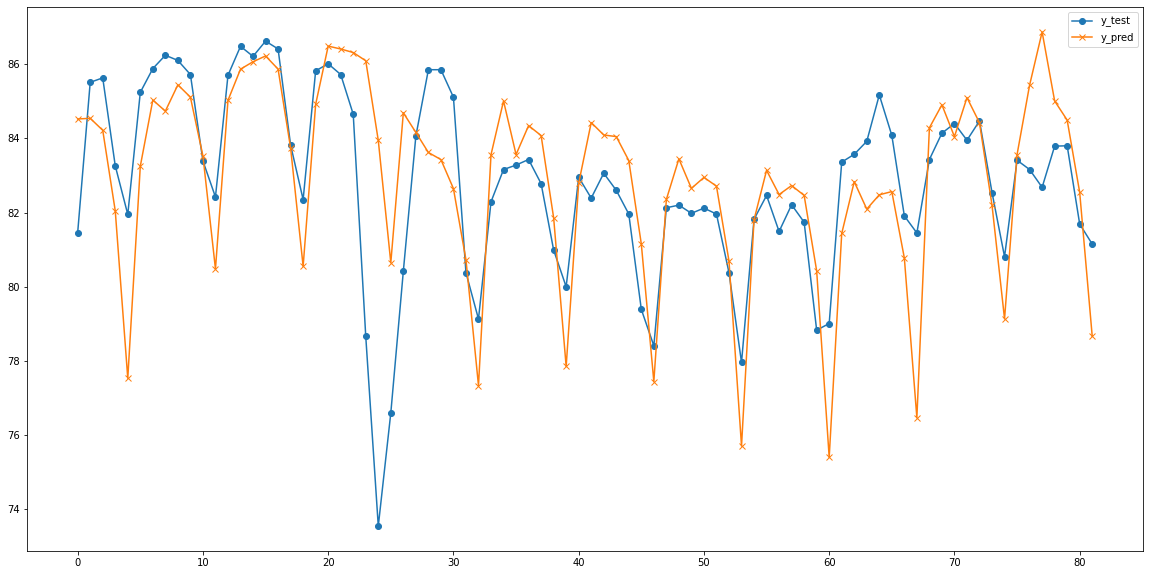

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(y_pred)), y_test[:-(window_size-1)], marker='o', label='y_test')
plt.plot(range(len(y_pred)), y_pred, marker='x', label='y_pred')
plt.legend()
plt.show()